In [1]:
import cv2
import joblib
import numpy as np
import os
import glob
import mahotas
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [2]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(0)
    return haralick

def fd_histogram(image, bins=8):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def fd_glcm(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    glcm = graycomatrix(gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    asm = graycoprops(glcm, 'ASM').flatten()
    
    return np.hstack([contrast, dissimilarity, homogeneity, energy, correlation, asm])

In [3]:
dataset_path = "./"
fixed_size = (300, 300)
bins = 8

In [4]:
global_features = []
labels = []

In [5]:
train_labels = os.listdir(dataset_path)
train_labels.sort()

In [6]:
for training_name in train_labels:
    dir = os.path.join(dataset_path, training_name)
    current_label = training_name
    
    if current_label in ['Bacterialblight', 'Brownspot','Healthy','LeafBlast']:
        print(current_label)
        file_list = glob.glob(os.path.join(dir, "*"))
        print(file_list)
        
        for file in file_list:
            image = cv2.imread(file)
            if image is None: continue
            
            image = cv2.resize(image, fixed_size)

            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image, bins)
            fv_glcm = fd_glcm(image) 

            global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments, fv_glcm])

            labels.append(current_label)
            global_features.append(global_feature)

Bacterialblight
['./Bacterialblight\\BACTERAILBLIGHT3_001.jpg', './Bacterialblight\\BACTERAILBLIGHT3_002.jpg', './Bacterialblight\\BACTERAILBLIGHT3_003.jpg', './Bacterialblight\\BACTERAILBLIGHT3_004.jpg', './Bacterialblight\\BACTERAILBLIGHT3_005.jpg', './Bacterialblight\\BACTERAILBLIGHT3_006.jpg', './Bacterialblight\\BACTERAILBLIGHT3_007.jpg', './Bacterialblight\\BACTERAILBLIGHT3_008.jpg', './Bacterialblight\\BACTERAILBLIGHT3_009.jpg', './Bacterialblight\\BACTERAILBLIGHT3_010.jpg', './Bacterialblight\\BACTERAILBLIGHT3_011.jpg', './Bacterialblight\\BACTERAILBLIGHT3_012.jpg', './Bacterialblight\\BACTERAILBLIGHT3_013.jpg', './Bacterialblight\\BACTERAILBLIGHT3_014.jpg', './Bacterialblight\\BACTERAILBLIGHT3_015.jpg', './Bacterialblight\\BACTERAILBLIGHT3_016.jpg', './Bacterialblight\\BACTERAILBLIGHT3_017.jpg', './Bacterialblight\\BACTERAILBLIGHT3_018.jpg', './Bacterialblight\\BACTERAILBLIGHT3_019.jpg', './Bacterialblight\\BACTERAILBLIGHT3_020.jpg', './Bacterialblight\\BACTERAILBLIGHT3_021.jp

label
LeafBlast          2589
Brownspot          2533
Bacterialblight    1994
Healthy            1914
Name: count, dtype: int64


<Axes: xlabel='label'>

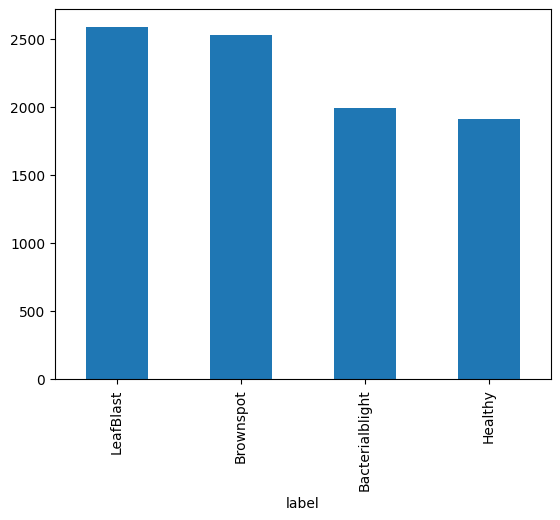

In [7]:
df = pd.DataFrame({"label": labels})

print(df["label"].value_counts())

df["label"].value_counts().plot(kind="bar")

In [8]:
le = LabelEncoder()
target = le.fit_transform(labels)

In [9]:
for cls, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{cls} -> {enc}")

Bacterialblight -> 0
Brownspot -> 1
Healthy -> 2
LeafBlast -> 3


In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(
    rescaled_features, target, test_size=0.2, random_state=42, stratify=target
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [12]:
num_classes = len(train_labels)
y_train_hot = to_categorical(y_train, num_classes)
y_val_hot   = to_categorical(y_val, num_classes)
y_test_hot  = to_categorical(y_test, num_classes)

In [13]:
model = Sequential()
input_dim = rescaled_features.shape[1]

model.add(Dense(512, activation='relu', input_shape=(input_dim,)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

c:\Users\Allen\Documents\Python Env\environments\computer_fusion\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit(
    X_train, y_train_hot,
    epochs=20,
    batch_size=20,
    validation_data=(X_val, y_val_hot),
    verbose=1
)

Epoch 1/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7143 - loss: 0.7143 - val_accuracy: 0.8483 - val_loss: 0.3799
Epoch 2/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8249 - loss: 0.4267 - val_accuracy: 0.8616 - val_loss: 0.3236
Epoch 3/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8450 - loss: 0.3742 - val_accuracy: 0.8749 - val_loss: 0.2978
Epoch 4/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8549 - loss: 0.3566 - val_accuracy: 0.8738 - val_loss: 0.3303
Epoch 5/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8643 - loss: 0.3333 - val_accuracy: 0.8804 - val_loss: 0.2807
Epoch 6/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8684 - loss: 0.3179 - val_accuracy: 0.8782 - val_loss: 0.2847
Epoch 7/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8706 - loss: 0.3145 - val_accuracy: 0.8915 - val_loss: 0.2784
Epoch 8/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8760 - loss: 0.3024 - val_accuracy: 0.

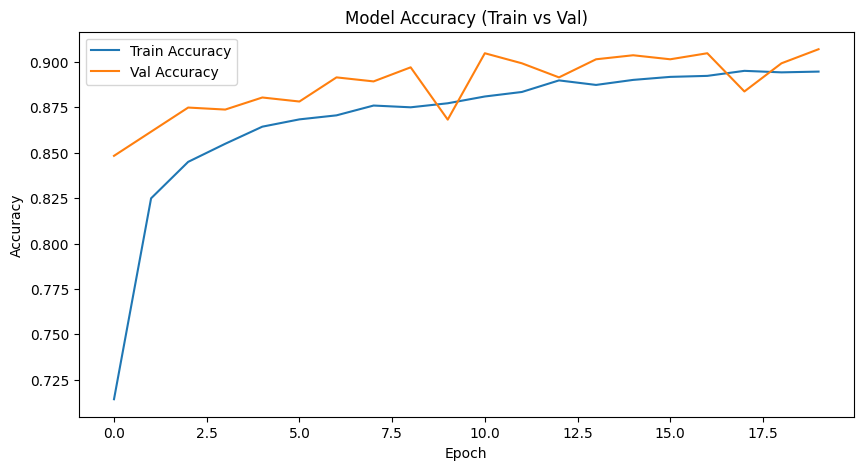

In [16]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (Train vs Val)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [17]:
results = model.evaluate(X_test, y_test_hot, batch_size=32)
print(f"\nTest Loss     : {results[0]:.4f}")
print(f"Test Accuracy : {results[1]*100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8926 - loss: 0.2563

Test Loss     : 0.2563
Test Accuracy : 89.26%


In [18]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_hot, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [19]:
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

                 precision    recall  f1-score   support

Bacterialblight       0.97      1.00      0.99       200
      Brownspot       0.95      0.91      0.93       253
        Healthy       0.74      0.91      0.81       191
      LeafBlast       0.93      0.78      0.85       259

       accuracy                           0.89       903
      macro avg       0.90      0.90      0.89       903
   weighted avg       0.90      0.89      0.89       903



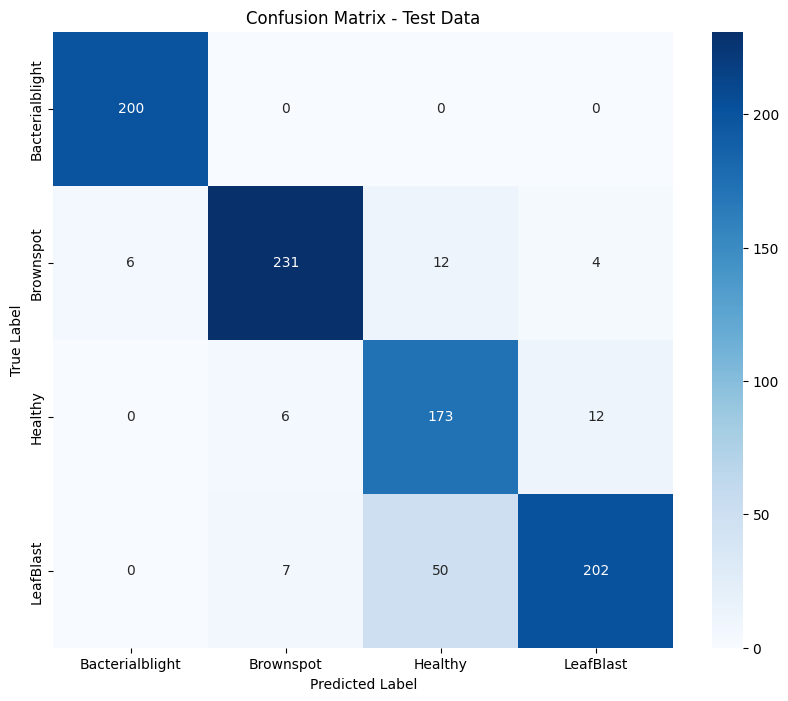

In [20]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [21]:
model.save("model_glcm.keras")

In [22]:
joblib.dump(scaler, "scaler_glcm.pkl")

['scaler_glcm.pkl']